# Data Preprocessing Steps

1. Running FFT analysis on SEEG data - log seizure times using Z
2. Running FFT projection into 2D tensors, or 3D tensors - log seizure times using preivous step
2D = [numsamps, numfreqs, W, H]
3D = [numsamps, numfreqs, W, H, D]

To project onto 2D or 3D, we will define a mesh grid of the image in brain MRI space. So the electrodes need to have defined xyz coordinates in the MRI (e.g. say freesurfer, or flirt space) when doing reconstructions.

Then each step will be saved with the corresponding data samples as a .npz file.

In [1]:
import sys
sys.path.append('../')
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility
import fragility.util.utils as futil
import datainterface.patient as Pat
# from fragility.signalprocessing import frequencyanalysis
# from datainterface import readmat

# sys.path.append('/home/adamli/tng_tvb/')
# from tvbsim import visualize

import os
import time

import numpy as np
import pandas as pd
import scipy
import scipy.io


import processing.util as util
import processing.frequencytransform as ft
import peakdetect
import processing.preprocessfft as preprocess

sys.path.append('/Users/adam2392/Documents/tvb/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
# from tvb.simulator.lab import *
import tvbsim.util

from natsort import natsorted
import ntpath
from scipy.signal import butter, lfilter

from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def _gettimepoints(numsignals, numwinsamps, numstepsamps):
    # create array of indices of window start times
    timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
    # create array of indices of window end times
    timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
    return timepoints

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y
def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='highpass', analog=False)
    return b, a
def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

# 1. Run FFT Analysis on All SEEG Simulated Data

SEEG Simulated data is assumed to be bandpass filtered when simulations were generated.
Run a check on the onset/offset times.

First, create a dataset from the old files with bandpass filtering ran on them (although these seizures are not as "realistic"), so keep this dataset separate until we loop them into the training procedure. In essence, if there were any that was bandpassed, then this would just essentially be adding another order to the butterworth filter (another convolution/multiplication).

Then create another dataset that is more robust starting from moved_v2 that has bandpass filtering already applied, and then store that dataset and keep appending, as I generate more and more data (_v3, v4, etc....)

*Need to add the index to start from the largest in the list in the directory so far, else = 0*

# 1b Run FFT On A Real Dataset
We choose la02

In [45]:
def extractrawdata(patient, datadir):
    '''
    This function takes in:
    1. patient name
    2. results directory (perturbation model)
    3. data directory, where all the raw metadata is held
    
    And extracts the data necessary for plotting
    '''
    # files to get resulting data and the original raw data / annotations
    rawdatafile = os.path.join(datadir,  patient, patient+'_rawnpy.npy')
    chanfile =  os.path.join(datadir,  patient, patient + '_chans.csv')
    headerfile = os.path.join(datadir,  patient, patient + '_headers.csv')
    annotationsfile = os.path.join(datadir,  patient, patient + '_annotations.csv')

    ################################ 1. LOAD DATA ###########################
    # instantiate a datainterface object to analyze data
    patieeg = Pat.PatientIEEG(patient, clinoutcome=None, engelscore=None, logfile=None)
    # get relevant channel data
    patid, seizid = futil.splitpatient(patient)
    included_chans, onsetchans, clinresult = fragility.util.utils.returnindices(patid, seizid)
    
    # set metadata to be used in analysis
    patieeg.setincludedchans(included_chans)
    patieeg.setmetadata_fromfile(headersfile=headerfile)
    patieeg.setchannels_fromfile(channelsfile=chanfile)
    patieeg.setannotations_fromfile(annotationsfile=annotationsfile)

    # get the data from files
    data = np.load(rawdatafile)
    
    return patieeg, data, included_chans, onsetchans

In [51]:
datadir = '/Volumes/ADAM LI/pydata/converted/'
patient='pt2sz1'
# load in the data for a real patient
patieeg, rawdata, included_chans, onsetchans = extractrawdata(patient, datadir)

rawdata=rawdata.T
print(patieeg)
print(rawdata.shape)
print(included_chans.shape)
print(onsetchans)

INFO:datainterface.patient:Initialized Patient IEEG object. Should run channels, metadata and annotations next!
INFO:datainterface.patient:Ran setup of meta data!
INFO:datainterface.patient:Ran setup of channels data!
INFO:datainterface.patient:Ran setup of annotations data!


(86, 313111)
(64,)
{'PST1', 'TT1', 'MST1', 'AST1'}


In [52]:
expname = 'clinpats'
traindir = os.path.join('/Volumes/ADAM LI/pydata/traindata/fft/', 
                        expname)
if not os.path.exists(traindir):
    os.makedirs(traindir)

# establish frequency bands
freqbands = {
        'dalpha':[0,15],
        'beta':[15,30],
        'gamma':[30,90],
        'high':[90,200],
    }
postprocessfft = preprocess.PreProcess(freqbands=freqbands)
# FFT Parameters
fs = 1000
winsize = 1000 # winsize in milliseconds
stepsize = 500 # stepsize in milliseconds
typetransform = 'fourier'
mtbandwidth = 4
mtfreqs = []

mtaper = ft.MultiTaperFFT(winsize, stepsize, fs, mtbandwidth, mtfreqs)

print(traindir)

Default method of tapering is eigen
/Volumes/ADAM LI/pydata/traindata/fft/clinpats


In [53]:
print(patieeg.onset_time)
print(patieeg.offset_time)
print(patieeg.chanlabels[included_chans])


105.9
204.74
['G1' 'G2' 'G3' 'G4' 'G5' 'G6' 'G7' 'G8' 'G9' 'G10' 'G13' 'G14' 'G15'
 'G16' 'G18' 'G19' 'G20' 'G21' 'G22' 'G23' 'G11' 'G12' 'G24' 'G26' 'G27'
 'G28' 'G29' 'G30' 'G31' 'G32' 'TT1' 'TT2' 'TT3' 'TT4' 'TT5' 'TT6' 'AST3'
 'AST4' 'MST1' 'MST2' 'MST3' 'MST4' 'PST1' 'PST2' 'PST3' 'PST4' 'OF1'
 'OF2' 'OF3' 'OF4' 'LF1' 'LF2' 'LF3' 'LF4' 'LF5' 'LF6' 'AST1' 'AST2' 'LP1'
 'LP2' 'LP3' 'LP4' 'LP5' 'LP6']


In [54]:
# for idx, datafile in enumerate(datafiles):
    # filter the data in case it was not done already
chanlabels = patieeg.chanlabels[included_chans]
  
# run FFT analysis
mtaper.loadrawdata(rawdata)
power, freqs, timepoints, _ = mtaper.mtwelch()
power = postprocessfft.binFrequencyValues(power, freqs)

onsettime = patieeg.onset_time
offsettime = patieeg.offset_time
# get seiztimes given onset/offset
if onsettime: 
    onset_indice = fragility.util.utils.converttimestowindow(timepoints, onsettime * fs)
if offsettime:
    offset_indice = fragility.util.utils.converttimestowindow(timepoints, offsettime * fs)
seiztimes = zip(onset_indice, offset_indice)
    
filename = os.path.join(traindir, 
                        patient + '_fft.npz')

np.savez_compressed(filename, 
                    power=power, 
                    timepoints=timepoints,
                    seiztimes=seiztimes,
                    seeg_contacts=chanlabels)
print(filename)
print(power.shape)
print(freqs.shape)
print(timepoints.shape)
print('\n\n')

Loaded raw data in MultiTaperFFT!
/Volumes/ADAM LI/pydata/traindata/fft/clinpats/pt2sz1_fft.npz
(86, 4, 625)
(501,)
(625, 2)





/Users/adam2392/Documents/dnn-unsupervised/dnn/processing/preprocessfft.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  power_binned[:,idx,:] = np.mean(power[:,indices[0]:indices[1]+1,:], axis=1) #[np.newaxis,:,:]


# 1b Run On Simulated Datasets

In [56]:
expname = 'varydistance/'
datadir = os.path.join('/Volumes/ADAM LI/pydata/tvbforwardsim/', expname)
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

# expname = 'allregions_notmoved'
traindir = os.path.join('/Volumes/ADAM LI/pydata/traindata/fft/', expname)

if not os.path.exists(traindir):
    os.makedirs(traindir)

# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
#     if 'allregions_sim' not in root:
    for file in files:
        if '.DS' not in file:
            datafiles.append(os.path.join(root, file))
print(len(datafiles))
# print(datafiles[50:])
# print(datafiles)

25


In [37]:
# establish frequency bands
freqbands = {
        'dalpha':[0,15],
        'beta':[15,30],
        'gamma':[30,90],
        'high':[90,200],
    }
postprocessfft = preprocess.PreProcess(freqbands=freqbands)

postprocessor = tvbsim.util.PostProcess([], [], [])

In [38]:
# FFT Parameters
fs = 1000
winsize = 1000 # winsize in milliseconds
stepsize = 500 # stepsize in milliseconds
typetransform = 'fourier'
mtbandwidth = 4
mtfreqs = []

mtaper = ft.MultiTaperFFT(winsize, stepsize, fs, mtbandwidth, mtfreqs)

Default method of tapering is eigen


In [57]:
for idx, datafile in enumerate(datafiles):
    filename = path_leaf(datafile)
    print(filename)
    
    data = np.load(datafile, encoding='bytes')
    metadata = data['metadata'].item()
    zts = data['zts']
    seegts = data['seegts']
    
    # Extract location coordinates
    locations = metadata[b'seeg_xyz']
    try:
        patient_id = metadata[b'patient'].decode("utf-8") 
    except:
        patient = '_'.join(filename.split('_')[0:2])

    ezindices = metadata[b'ezindices']
    pzindices = metadata[b'pzindices']
    x0 = metadata[b'x0ez']
    seeg_contacts = metadata[b'seeg_contacts']

    # get the actual seizure times and offsets
    settimes = postprocessor.getonsetsoffsets(zts, 
                np.array(ezindices), np.array(pzindices), delta=0.2/5)
    seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)
    
    # filter the data in case it was not done already
    lowcut = 0.1
    highcut = 499.
    fs = 1000.
    newseegts = butter_bandpass_filter(seegts, lowcut, highcut, fs, order=4)

    mtaper.loadrawdata(newseegts)
    power, freqs, timepoints, _ = mtaper.mtwelch()
    power = postprocessfft.binFrequencyValues(power, freqs)
    
    filename = os.path.join(traindir, 
            patient_id + '_nez' + str(len(ezindices)) + '_npz' + str(len(pzindices)) + \
                            '_'+str(idx) +'.npz')
    np.savez_compressed(filename, 
                        power=power, 
                        timepoints=timepoints,
                        seizonsets=seizonsets,
                        seizoffsets=seizoffsets,
                        locs=locations,
                        seeg_contacts=seeg_contacts,
                        x0ez=x0)
    print(datafile)
    print(power.shape)
    print(seizonsets, seizoffsets)
#     print(freqs.shape)
#     print(timepoints.shape)
#     print(locations.shape)
#     print(seeg_contacts.shape)
    print('\n\n')
#     break

id001_ac_sim_nez1_npz1.npz
Loaded raw data in MultiTaperFFT!


/Users/adam2392/Documents/dnn-unsupervised/dnn/processing/preprocessfft.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  power_binned[:,idx,:] = np.mean(power[:,indices[0]:indices[1]+1,:], axis=1) #[np.newaxis,:,:]


/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist7/id001_ac_sim_nez1_npz1.npz
(70, 4, 439)
[30231.0, 140450.0] [94757.0]



id002_cj_sim_nez1_npz1.npz
Loaded raw data in MultiTaperFFT!
/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist7/id002_cj_sim_nez1_npz1.npz
(162, 4, 439)
[55087.0] []



id014_rb_sim_nez1_npz1.npz
Loaded raw data in MultiTaperFFT!
/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist7/id014_rb_sim_nez1_npz1.npz
(165, 4, 439)
[29831.0, 143312.0] [110935.0]



id001_ac_sim_nez1_npz1.npz
Loaded raw data in MultiTaperFFT!
/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist1/id001_ac_sim_nez1_npz1.npz
(70, 4, 235)
[24514.0] []



id002_cj_sim_nez1_npz1.npz
Loaded raw data in MultiTaperFFT!
/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist1/id002_cj_sim_nez1_npz1.npz
(162, 4, 229)
[28817.0] []



id014_rb_sim_nez1_npz1.npz
Loaded raw data in MultiTaperFFT!
/Volumes/ADAM LI/pydata/tvbforwardsim/vary

# 2. Run Image Transformation in 2D onto a Mesh grid

In [ ]:
postprocessor = tvbsim.util.PostProcess([], [], [])

# determine where norm, pz and ez are
ezindices = np.where(config.model.x0 == x0ez)[0]
pzindices = np.where(config.model.x0 == x0pz)[0]

seizonsets = []
seizoffsets = []
settimes = postprocessor.getonsetsoffsets(zts, np.array(ezindices), np.asarray(pzindices), delta=0.2/5)
# get the actual seizure times and offsets
seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)

In [14]:
'''
This code segment should only be ran once, to extract metadata for each patient, 
so it doesn't need to be done in the loop for FFT compression.

EXTRACTS LOCATION DATA FOR EACH PATIENT
'''
# patients = []
# # get all patients in the dataset
# for datafile in datafiles:
#     filename = path_leaf(datafile)
#     patient = '_'.join(filename.split('_')[0:2])
#     if patient not in patients:
#         patients.append(patient)
# print(patients)

patients = ['id001_ac', 'id002_cj', 'id014_rb']
patient_dict = {}

# get all metadata for each patient
for patient in patients:
    project_dir = os.path.join(metadatadir, patient)
    confile = os.path.join(project_dir, "connectivity.zip")

    # get the regions, and region_centers from connectivity
    reader = util.ZipReader(confile)
    region_centers = reader.read_array_from_file("centres", use_cols=(1, 2, 3))
    regions = reader.read_array_from_file("centres", dtype=np.str, use_cols=(0,))
print(patient_dict.keys())

dict_keys([])


In [15]:
expname = 'varydistance_2'
datadir = os.path.join('/Volumes/ADAM LI/pydata/traindata/fft/', expname)
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        if file.endswith(".npz"):
             datafiles.append(os.path.join(root, file))
# print(datafiles)
print(len(datafiles))

24


In [16]:
# define the data handler 
datahandler = util.DataHandler()
pca = PCA(n_components=2)

AZIM=0
trainimagedir = os.path.join('/Volumes/ADAM LI/pydata/traindata/image_2d/', expname)
metadir = os.path.join('/Volumes/ADAM LI/pydata/traindata/image_2d/', expname,
                       'meta/')
if not os.path.exists(trainimagedir):
    os.makedirs(trainimagedir)
# loop through each data file and get grid
for idx,datafile in enumerate(datafiles):
    # load data
    data = np.load(datafile, encoding='bytes')
    power = data['power']
    print(power.shape)
    print(data.keys())
    
    # load xyz data for this particular dataset
    xyz_data = data['locs']
    seeg_contacts = data['seeg_contacts']
    x0ez = data['x0ez']
    seizonsets = data['seizonsets']
    seizoffsets = data['seizoffsets']
    timepoints = data['timepoints']
    
    # project xyz data
    if AZIM==1:
        print("using azim projection to grid image")
        new_locs = []
        for ichan in range(0,xyz_data.shape[0]):
            new_locs.append(datahandler.azim_proj(xyz_data[ichan,:]))
        new_locs = np.asarray(new_locs)
    if AZIM==0:
        print("using pca to grid image")
        new_locs = pca.fit_transform(xyz_data)
    
    ylabels = datahandler.computelabels(seizonsets,seizoffsets, timepoints)
    
    if len(seizonsets) <= 1 and seizonsets[0] == np.nan:
        print("skipping ", datafile)
    else:
        # Tensor of size [samples, freqbands, W, H] containing generated images.
        image_tensor = datahandler.gen_images(new_locs, power, 
                                n_gridpoints=32, normalize=True, augment=False, 
                                pca=False, std_mult=0.1, edgeless=False)

    print(image_tensor.shape)
    # set saving file paths for image and corresponding meta data
    filename = path_leaf(datafile)
    imagefilename = os.path.join(trainimagedir, filename)
    metafilename = os.path.join(metadir, filename)
    
    # instantiate metadata hash table
    metadata = dict()
    metadata['x0ez'] = x0ez
    metadata['seeg_contacts'] = seeg_contacts
    metadata['new_locs'] = new_locs
    metadata['ylabels'] = ylabels
    
    # save image and meta data
    np.savez(imagefilename, image_tensor=image_tensor, metadata=metadata)
#     np.savez_compressed(metafilename, metadata=metadata)
    
    print(new_locs.shape)
#     break

(70, 4, 359)
['power', 'timepoints', 'seizonsets', 'seizoffsets', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
(359, 70)
(359, 4, 32, 32)9/359nterpolating 92/359Interpolating 137/359Interpolating 184/359Interpolating 233/359Interpolating 281/359Interpolating 327/359
(70, 2)
(70, 4, 359)
['power', 'timepoints', 'seizonsets', 'seizoffsets', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
(359, 70)
(359, 4, 32, 32)8/359nterpolating 31/359Interpolating 70/359Interpolating 114/359Interpolating 164/359Interpolating 213/359Interpolating 261/359Interpolating 310/359Interpolating 359/359
(70, 2)
(70, 4, 359)
['power', 'timepoints', 'seizonsets', 'seizoffsets', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
(359, 70)
Interpolating 359/359nterpolating 21/359Interpolating 69/359Interpolating 118/359Interpolating 165/359Interpolating 214/359Interpolating 263/359Interpolating 312/359(359, 4, 32, 32)
(70, 2)
(70, 4, 359)
['power', 'timepoints', 'seizonsets', 'seizoffset

(359, 4, 32, 32)9/359nterpolating 29/359Interpolating 93/359Interpolating 125/359Interpolating 156/359Interpolating 187/359Interpolating 216/359Interpolating 244/359Interpolating 274/359Interpolating 305/359Interpolating 335/359
(165, 2)
(165, 4, 359)
['power', 'timepoints', 'seizonsets', 'seizoffsets', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
(359, 165)
(359, 4, 32, 32)9/359nterpolating 31/359Interpolating 63/359Interpolating 94/359Interpolating 126/359Interpolating 157/359Interpolating 189/359Interpolating 220/359Interpolating 250/359Interpolating 282/359Interpolating 313/359Interpolating 345/359
(165, 2)


In [32]:
print(datafile)
print(seizonsets)
print(seizoffsets)
# for idx in range(2):
#     print(idx)

/Volumes/ADAM LI/pydata/traindata/fft/allregions_moved/id001_ac_nez1_npz1_22.npz
[nan]
[]


In [5]:
expname = 'allregions_notmoved'
trainimagedir = os.path.join('/Volumes/ADAM LI/pydata/dnn/traindata/image_2d/', expname)
# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(trainimagedir):
    for file in files:
        if file.endswith(".npz"):
             datafiles.append(os.path.join(root, file))
# print(datafiles)
print(len(datafiles))

83


(239, 4, 32, 32)
(239, 4, 32, 32)


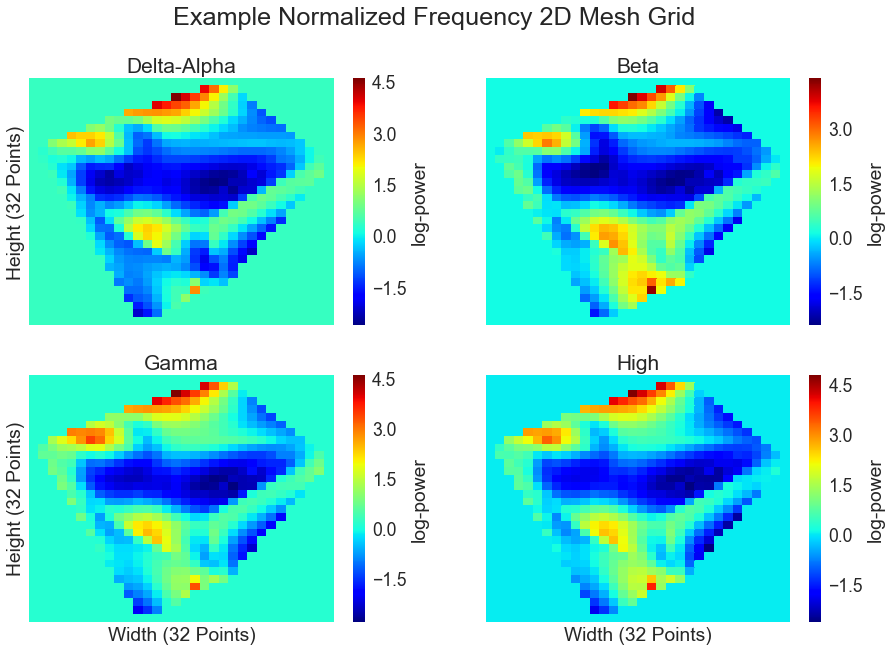

In [36]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

filename = path_leaf(datafiles[0])
filepath = os.path.join(trainimagedir, filename)
data = np.load(filepath)
imagetensor = data['image_tensor']
metadata = data['metadata'].item()
print(imagetensor.shape)

def normalizeimage(imagetensor):
    # assumes imagetensor shape is [nsamps, nchans, width, height]
    temptensor = imagetensor.reshape((imagetensor.shape[0], imagetensor.shape[1], -1))
    
    # get average/std and store temporary
    avg = np.mean(temptensor, axis=-1, keepdims=True)
    std = np.std(temptensor, axis=-1, keepdims=True)
    
    temptensor = np.subtract(temptensor, avg)
    temptensor = np.divide(temptensor,std)
    imagetensor = temptensor.reshape((temptensor.shape[0], imagetensor.shape[1], 32, 32))
    return imagetensor

imagetensor = normalizeimage(imagetensor)
print(imagetensor.shape)

titlestr = ['Delta-Alpha', 'Beta', 'Gamma', 'High']

fig = plt.figure(figsize=(15,10))
supax = plt.gca()
supax.set_title('Example Normalized Frequency 2D Mesh Grid')
sns.set(font_scale=1.75)
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.heatmap(imagetensor[0,i,:,:], 
                cmap='jet', 
                cbar_kws={'label': 'log-power'})
    ax = plt.gca()
    ax.set_title(titlestr[i])
    ax.set_xticks([])
    ax.set_yticks([])
    if i==0 or i==2:
        ax.set_ylabel('Height (32 Points)')
    if i==2 or i==3:
        ax.set_xlabel('Width (32 Points)')
#     if i > 0:
#         clim[0] = np.min(clim[0], ax.clim()[0])
#         clim[1] = np.max(clim[1], ax.clim()[1])
#     else:
#         clim = ax.clim()
plt.suptitle('Example Normalized Frequency 2D Mesh Grid')
plt.show()

In [39]:
traindatadir = '/Volumes/ADAM LI/pydata/dnn/traindata/finaldata/'
imagefile = os.path.join(traindatadir, 'allimages_2d.npz')

data = np.load(imagefile)
image_tensor = data['images']
print(data.keys())
print(image_tensor.shape)

['images', 'labels']
(59585, 4096)


# 3. Process FFT Analysis into a 3D Mesh Grid

Here, I need to just redefine how to generate images with the data handler class. I need to reate a mesh grid on the 3D space now instead of just on the 2D space.

I will name this new function gen_images3d

In [62]:
expname = 'allregions_moved'
datadir = os.path.join('/Volumes/ADAM LI/pydata/traindata/fft/', expname)
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        if file.endswith(".npz"):
             datafiles.append(os.path.join(root, file))
# print(datafiles)
print(len(datafiles))

84


In [63]:
# define the data handler 
datahandler = util.DataHandler()

trainimagedir = os.path.join('/Volumes/ADAM LI/pydata/traindata/image_3d/',expname)
if not os.path.exists(trainimagedir):
    os.makedirs(trainimagedir)
    
# loop through each data file and get grid
for idx,datafile in enumerate(datafiles):
    # load data
    data = np.load(datafile, encoding='bytes')
    power = data['power']
    print(power.shape)
    print(data.keys())
    
    # load xyz data for this particular dataset
    xyz_data = data['locs']
    seeg_contacts = data['seeg_contacts']
    x0ez = data['x0ez']
    seizonsets = data['seizonsets']
    seizoffsets = data['seizoffsets']
    timepoints = data['timepoints']

    ylabels = datahandler.computelabels(seizonsets,seizoffsets, timepoints)
       
    # Tensor of size [samples, freqbands, W, H] containing generated images.
    image_tensor = datahandler.gen_images3d(xyz_data, power, 
                                n_gridpoints=32, normalize=True, augment=False, 
                                std_mult=0.1, edgeless=False)

    print(image_tensor.shape)
    # set saving file paths for image and corresponding meta data
    filename = path_leaf(datafile)
    imagefilename = os.path.join(trainimagedir, filename)
    
    # instantiate metadata hash table
    metadata = dict()
    metadata['x0ez'] = x0ez
    metadata['seeg_contacts'] = seeg_contacts
    metadata['seeg_xyz'] = xyz_data
    metadata['ylabels'] = ylabels
    
    # save image and meta data
    np.savez_compressed(imagefilename, image_tensor=image_tensor, metadata=metadata)

(70, 4, 239)
['power', 'timepoints', 'seizonsets', 'seizoffsets', 'locs', 'seeg_contacts', 'x0ez']
(239, 70)
Interpolating 239/239nterpolating 22/239Interpolating 33/239Interpolating 44/239Interpolating 54/239Interpolating 65/239Interpolating 77/239Interpolating 89/239Interpolating 100/239Interpolating 110/239Interpolating 122/239Interpolating 133/239Interpolating 144/239Interpolating 156/239Interpolating 168/239Interpolating 180/239Interpolating 192/239Interpolating 204/239Interpolating 216/239Interpolating 227/239Interpolating 237/239(239, 4, 32, 32, 32)
(70, 4, 239)
['power', 'timepoints', 'seizonsets', 'seizoffsets', 'locs', 'seeg_contacts', 'x0ez']
(239, 70)
Interpolating 239/239terpolating 9/239Interpolating 19/239Interpolating 30/239Interpolating 41/239Interpolating 53/239Interpolating 65/239Interpolating 77/239Interpolating 89/239Interpolating 101/239Interpolating 113/239Interpolating 125/239Interpolating 136/239Interpolating 147/239Interpolating 158/239Interpolating 170/239Int

Interpolating 239/239terpolating 9/239Interpolating 33/239Interpolating 45/239Interpolating 57/239Interpolating 69/239Interpolating 81/239Interpolating 93/239Interpolating 105/239Interpolating 117/239Interpolating 129/239Interpolating 141/239Interpolating 153/239Interpolating 164/239Interpolating 175/239Interpolating 187/239Interpolating 199/239Interpolating 211/239Interpolating 223/239Interpolating 235/239(239, 4, 32, 32, 32)
(70, 4, 239)
['power', 'timepoints', 'seizonsets', 'seizoffsets', 'locs', 'seeg_contacts', 'x0ez']
(239, 70)
Interpolating 238/239terpolating 9/239Interpolating 21/239Interpolating 33/239Interpolating 45/239Interpolating 57/239Interpolating 69/239Interpolating 81/239Interpolating 93/239Interpolating 105/239Interpolating 117/239Interpolating 129/239Interpolating 141/239Interpolating 153/239Interpolating 166/239Interpolating 178/239Interpolating 191/239Interpolating 203/239Interpolating 215/239Interpolating 227/239Interpolating 239/239(239, 4, 32, 32, 32)
(70, 4, 2

Interpolating 238/239terpolating 9/239Interpolating 22/239Interpolating 35/239Interpolating 48/239Interpolating 61/239Interpolating 73/239Interpolating 86/239Interpolating 99/239Interpolating 111/239Interpolating 124/239Interpolating 137/239Interpolating 150/239Interpolating 163/239Interpolating 175/239Interpolating 201/239Interpolating 214/239Interpolating 227/239Interpolating 239/239(239, 4, 32, 32, 32)
(70, 4, 239)
['power', 'timepoints', 'seizonsets', 'seizoffsets', 'locs', 'seeg_contacts', 'x0ez']
(239, 70)
Interpolating 239/239terpolating 9/239Interpolating 21/239Interpolating 33/239Interpolating 45/239Interpolating 57/239Interpolating 69/239Interpolating 81/239Interpolating 93/239Interpolating 106/239Interpolating 118/239Interpolating 130/239Interpolating 142/239Interpolating 154/239Interpolating 166/239Interpolating 178/239Interpolating 190/239Interpolating 202/239Interpolating 214/239Interpolating 226/239Interpolating 238/239(239, 4, 32, 32, 32)
(70, 4, 239)
['power', 'timepoi

Interpolating 239/239terpolating 10/239Interpolating 23/239Interpolating 36/239Interpolating 49/239Interpolating 62/239Interpolating 75/239Interpolating 88/239Interpolating 114/239Interpolating 127/239Interpolating 140/239Interpolating 153/239Interpolating 166/239Interpolating 179/239Interpolating 191/239Interpolating 204/239Interpolating 217/239Interpolating 230/239(239, 4, 32, 32, 32)
(70, 4, 239)
['power', 'timepoints', 'seizonsets', 'seizoffsets', 'locs', 'seeg_contacts', 'x0ez']
(239, 70)
Interpolating 239/239terpolating 10/239Interpolating 23/239Interpolating 36/239Interpolating 48/239Interpolating 60/239Interpolating 72/239Interpolating 84/239Interpolating 97/239Interpolating 110/239Interpolating 122/239Interpolating 134/239Interpolating 147/239Interpolating 160/239Interpolating 173/239Interpolating 186/239Interpolating 199/239Interpolating 212/239Interpolating 224/239Interpolating 237/239(239, 4, 32, 32, 32)
(70, 4, 239)
['power', 'timepoints', 'seizonsets', 'seizoffsets', 'loc

In [27]:
import matplotlib
import matplotlib.pyplot as plt

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    
    # initialize figure to draw on
    fig, ax = plt.subplots()
    ax.volume = volume
    
    # set index as the first axis
    ax.index = volume.shape[2] // 2
    ax.imshow(volume[ax.index], cmap='jet',origin='lower')

    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j': # go to previous slice
        previous_slice(ax)
    elif event.key == 'k': # go to next slice
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    
def remove_keymap_conflicts(new_keys_set):
    '''
    a helper function to remove keys that we want 
    to use wherever they may appear in this dictionary.
    '''
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
    

<IPython.core.display.Javascript object>


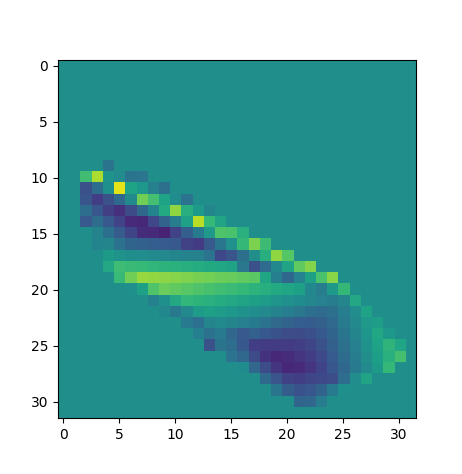

In [59]:
# fig, ax = plt.subplots()
# ax.imshow(image_tensor[0,0,:,:,:])
# fig.canvas.mpl_connect('key_press_event', process_key)
%matplotlib notebook
multi_slice_viewer(image_tensor[0,0,:,:,:])

In [56]:
expname = 'allregions_moved'
trainimagedir = os.path.join('/Volumes/ADAM LI/pydata/traindata/image_3d/', expname)
# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(trainimagedir):
    for file in files:
        if file.endswith(".npz"):
             datafiles.append(os.path.join(root, file))
# print(datafiles)
print(len(datafiles))

%matplotlib notebook

84


In [61]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

filename = path_leaf(datafiles[0])
filepath = os.path.join(trainimagedir, filename)
data = np.load(filepath)
print(data.keys())
imagetensor = data['imagetensor']
print(imagetensor.shape)

# plt.figure(figsize=(15,10))
# for i in range(4):
#     plt.subplot(2,2,i+1)
#     multi_slice_viewer(imagetensor[0,i,:,:,:])
#     ax = plt.gca()
multi_slice_viewer(imagetensor[0,1,:,:,:])   
#     if i > 0:
#         clim[0] = np.min(clim[0], ax.clim()[0])
#         clim[1] = np.max(clim[1], ax.clim()[1])
#     else:
#         clim = ax.clim()


['metadata', 'arr_0']


KeyError: 'imagetensor is not a file in the archive'